In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from shapely.affinity import rotate
import numpy as np
import os
from shapely.geometry import Point


In [2]:
data=pd.read_csv('measurementRectangles.csv')
data=data[['brand',
 'style',
 'menWomen',
 'name',
 'fabric',
 'price',
 'maxHeightFront',
 'minHeightFront',
 'rivetHeightFront',
 'maxWidthFront',
 'minWidthFront',
 'maxHeightBack',
 'minHeightBack',
 'maxWidthBack',
 'minWidthBack',
 'cutout',
 'waistSize',
 'updatedStyle',
 'group',
 'priceGroup',
#  'pocketArea',
#  'rectanglePhone/area',
#  'rectanglePhone/cx',
#  'rectanglePhone/cy',
#  'rectanglePhone/width',
#  'rectanglePhone/height',
#  'rectanglePhone/angle',
#  'rectanglePhone/points/0/0',
#  'rectanglePhone/points/0/1',
#  'rectanglePhone/points/1/0',
#  'rectanglePhone/points/1/1',
#  'rectanglePhone/points/2/0',
#  'rectanglePhone/points/2/1',
#  'rectanglePhone/points/3/0',
#  'rectanglePhone/points/3/1',
#  'rectanglePhone/points/4/0',
#  'rectanglePhone/points/4/1',
#  'rectanglePhone/heightCM',
#  'rectanglePhone/widthCM',
          ]]

In [3]:
# create points from measurements. 
data['front_x1']=0
data['front_y1']=0

data['front_x2']=0
data['front_y2']=data.maxHeightFront+data.front_y1

data['front_x3']=data.front_x2+data.maxWidthFront-data.minWidthFront
data['front_y3']=data.front_y2

data['front_x4']=data.front_x3+data.minWidthFront
data['front_y4']=data.front_y2-data.rivetHeightFront

data['front_x5']=data.front_x4
data['front_y5']=data.front_y2-data.minHeightFront

#------------------------------------
data['back_x1']=0
data['back_y1']=0

data['back_x2']=data.back_x1- ((data.maxWidthBack-data.minWidthBack)/2)
data['back_y2']=data.minHeightBack+data.back_y1

data['back_x3']=data.back_x2+data.maxWidthBack
data['back_y3']=data.back_y2

data['back_x4']=data.back_x3- ((data.maxWidthBack-data.minWidthBack)/2)
data['back_y4']=data.back_y1

data['back_x5']=data.back_x1+data.minWidthBack/2
data['back_y5']=data.back_y1+data.minHeightBack-data.maxHeightBack


# test and plot 

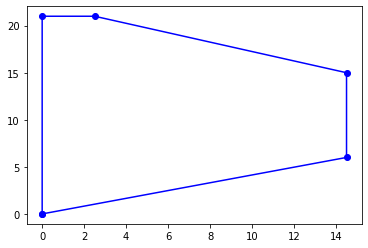

In [6]:
# Define the dimensions of the pocket as vertices of a polygon
polygon_vertices = np.array([[data['front_x1'][5], data['front_y1'][5]], 
                             [data['front_x2'][5], data['front_y2'][5]], 
                             [data['front_x3'][5], data['front_y3'][5]], 
                             [data['front_x4'][5], data['front_y4'][5]],
                            [data['front_x5'][5], data['front_y5'][5]],
                             [data['front_x1'][5], data['front_y1'][5]],
                            ])

# Extract x and y coordinates of the vertices
x, y = polygon_vertices[:, 0], polygon_vertices[:, 1]
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Pocket')



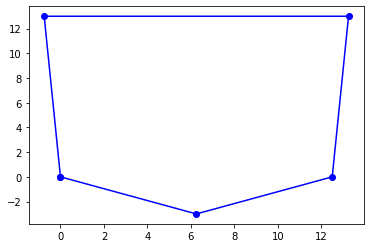

In [7]:
# Define the dimensions of the pocket as vertices of a polygon
polygon_vertices = np.array([[data['back_x1'][0], data['back_y1'][0]], 
                             [data['back_x2'][0], data['back_y2'][0]], 
                             [data['back_x3'][0], data['back_y3'][0]], 
                             [data['back_x4'][0], data['back_y4'][0]],
                            [data['back_x5'][0], data['back_y5'][0]],
                              [data['back_x1'][0], data['back_y1'][0]],
                            ])

# Extract x and y coordinates of the vertices
x, y = polygon_vertices[:, 0], polygon_vertices[:, 1]
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Pocket')


# add curve for bottom and up. assume 30 degree
# Note: I only used bottome here. upper curve not used for now. 


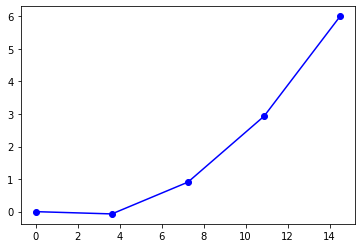

In [25]:
# add only 5 points for curve. not 10. too much calculation

def create_smooth_curve(point1, point2, angle_degrees, num_points=5):

    angle_radians = np.deg2rad(angle_degrees)
    t = np.linspace(0, 1, num_points)
    x_curve = (1 - t) * point1[0] + t * point2[0]
    y_curve = (1 - t) * point1[1] + t * point2[1] + (t * (1 - t) * np.tan(angle_radians) * (point2[0] - point1[0]))
    return x_curve, y_curve

# Example usage:
point1 = (data['front_x1'][5], data['front_y1'][5])
point2 = (data['front_x5'][5], data['front_y5'][5])
angle_degrees = -30

x_curve, y_curve = create_smooth_curve(point1, point2, angle_degrees)
plt.plot(x_curve, y_curve, marker='o', linestyle='-', color='b', label='Smooth Curve')



In [26]:
# create front pocket bottom curve 
data['front_bottom_curve_x'] = data.apply(lambda row: create_smooth_curve((row['front_x1'], row['front_y1']),
                                                                (row['front_x5'], row['front_y5']),
                                                                -30)[0],
                                  axis=1)
data['front_bottom_curve_y'] = data.apply(lambda row: create_smooth_curve((row['front_x1'], row['front_y1']),
                                                                (row['front_x5'], row['front_y5']),
                                                                -30)[1],
                                  axis=1)


In [27]:
# create front pocket top curve, not used in the future. 

data['front_top_curve_x'] = data.apply(lambda row: create_smooth_curve((row['front_x3'], row['front_y3']),
                                                                (row['front_x4'], row['front_y4']),
                                                                -30)[0],
                                  axis=1)
data['front_top_curve_y'] = data.apply(lambda row: create_smooth_curve((row['front_x3'], row['front_y3']),
                                                                (row['front_x4'], row['front_y4']),
                                                                -30)[1],
                                  axis=1)


# zip data x y points and curves

In [30]:
# Custom function to create a list with 'a' as the first element and 'b' as the rest
def create_list(row):
    b_array = row['front_bottom_curve_x']

        # Remove the first and last elements, then reverse
    processed_b = b_array[1:-1][::-1]


    return np.concatenate(([row['front_x1']],[row['front_x2']],[row['front_x3']],
        [row['front_x4']], [row['front_x5']],processed_b))
  # Convert to list
    
    
def create_list2(row):
    b_array = row['front_bottom_curve_y']

        # Remove the first and last elements, then reverse
    processed_b = b_array[1:-1][::-1]


    return np.concatenate(([row['front_y1']],[row['front_y2']],[row['front_y3']],
        [row['front_y4']], [row['front_y5']],processed_b))
  # Convert to list

# Create a new column 'c' using apply and the custom function
data['front_x'] = data.apply(create_list, axis=1)
data['front_y'] = data.apply(create_list2, axis=1)



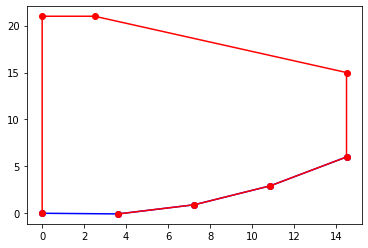

In [33]:
plt.plot(data['front_bottom_curve_x'][5], data['front_bottom_curve_y'][5], marker='o', linestyle='-', color='b', label='Smooth Curve')

plt.plot(data['front_x'][5], data['front_y'][5], marker='o', linestyle='-', color='r', label='Smooth Curve')
def zip_arrays1(row):
    return list(zip(row['front_bottom_curve_x'], row['front_bottom_curve_y']))

def zip_arrays2(row):
    return list(zip(row['front_x'], row['front_y']))

data['front_coordinate_plot'] = data.apply(zip_arrays2, axis=1)
data['front_coordinate_generate'] = data.apply(zip_arrays1, axis=1)


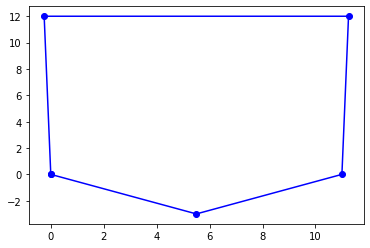

In [34]:
    
def create_list3(row):
    return np.concatenate(([row['back_x1']],[row['back_x2']],[row['back_x3']],
        [row['back_x4']], [row['back_x5']],[row['back_x1']]))
def create_list4(row):
    return np.concatenate(([row['back_y1']],[row['back_y2']],[row['back_y3']],
        [row['back_y4']], [row['back_y5']],[row['back_y1']]))
data['back_x'] = data.apply(create_list3, axis=1)
data['back_y'] = data.apply(create_list4, axis=1)
plt.plot(data['back_x'][5], data['back_y'][5], marker='o', linestyle='-', color='b', label='Smooth Curve')


# find largest rectange with aspect ratio of 19.5:9 = 2.17
#  will rotate the phone/pocket if needed


In [35]:
coordinates = list(zip(data['front_x'][5], data['front_y'][5]))
coordinates


def zip_arrays1(row):
    return list(zip(row['front_x'], row['front_y']))

def zip_arrays2(row):
    return list(zip(row['back_x'], row['back_y']))

data['front_coordinate'] = data.apply(zip_arrays1, axis=1)
data['back_coordinate'] = data.apply(zip_arrays2, axis=1)


In [36]:
data['front_coordinate'][0]

[(0.0, 0.0),
 (0.0, 21.5),
 (4.0, 21.5),
 (16.5, 14.5),
 (16.5, -1.5),
 (12.375, -2.911177395305404),
 (8.25, -3.1315698604072058),
 (4.125, -2.161177395305404)]

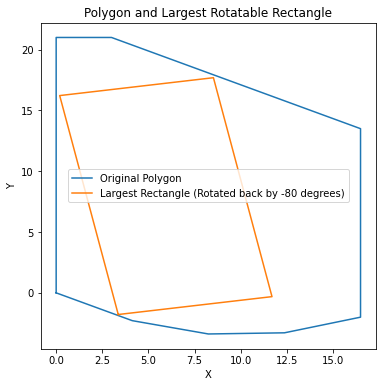

In [62]:


def find_largest_rectangle(polygon, aspect_ratio):
    minx, miny, maxx, maxy = polygon.bounds
    best_area = 0
    best_rect = None

    # Iterate over a grid within the polygon bounds
    for x in np.linspace(minx, maxx, 100): ##### --------------------change this 100 to 50 to faster calculate
        for y in np.linspace(miny, maxy, 100):##### --------------------change this 100 to 50 to faster calculate
            for dx in np.linspace(0, maxx - x, 50):
                dy = dx / aspect_ratio
                rect = box(x, y, x + dx, y + dy)
                if polygon.contains(rect) and rect.area > best_area:
                    best_area = rect.area
                    best_rect = rect
                    best_len = best_rect.bounds[2] - best_rect.bounds[0]
                    best_wid = best_rect.bounds[3] - best_rect.bounds[1]
                    aspect_ratio=max(best_len,best_wid)/min(best_wid,best_len)
    return best_rect,aspect_ratio

def rotate_polygon_and_find_largest_rectangle(points, aspect_ratio):
    original_polygon = Polygon(points)
    centroid = original_polygon.centroid.coords[0]
    best_area = 0
    best_rect = None
    best_angle = 0

    for angle in range(0, 180, 20):##### ---------change this 20 to 30 to faster calculate, 20 degree step
        rotated_polygon = rotate(original_polygon, angle, origin=centroid)
        rect,aspect_ratio = find_largest_rectangle(rotated_polygon, aspect_ratio)
        if rect and rect.area > best_area and aspect_ratio>2.1 and aspect_ratio< 2.2:
            best_area = rect.area
            best_rect = rotate(rect, -angle, origin=centroid)
            best_angle = angle
            best_length2 = best_rect.bounds[2] - best_rect.bounds[0]
            best_width2 = best_rect.bounds[3] - best_rect.bounds[1]

    return best_rect, best_angle

# Example polygon points
#points = [(2, 3), (5, 11), (12, 8), (9, 5), (5, 6)]
points=data['front_coordinate'][1]
# Find the largest rectangle with aspect ratio 2 after rotating the polygon
largest_rectangle, rotation_degree = rotate_polygon_and_find_largest_rectangle(points, 2.16)

# Plot the original polygon and the largest rectangle
polygon = Polygon(points)
x, y = polygon.exterior.xy
plt.figure(figsize=(6, 6))
plt.plot(x, y, label="Original Polygon")

if largest_rectangle:
    x, y = largest_rectangle.exterior.xy
    plt.plot(x, y, label=f"Largest Rectangle (Rotated back by {-rotation_degree} degrees)")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polygon and Largest Rotatable Rectangle')
plt.legend()
plt.show()


154.70517155841534
[(3.3654391610448178, -1.7811175615975454), (11.699890192607594, -0.31152897533952917), (8.525578846290287, 17.690885252836022), (0.1911278147275104, 16.221296666578006), (3.3654391610448178, -1.7811175615975454)]


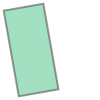

In [63]:
# this is the rectangel of in image above. some commands to take parameter out. 
print(largest_rectangle.area)
print(list(largest_rectangle.exterior.coords))
largest_rectangle 


# Susan, run 3 -5 instead of whole data below
will take forever to run all 80 pants. 

In [64]:
data=data[0:3]# susan, run olny!!!!!!!


data[['polygon_front','poly_angle_front']]=data['front_coordinate'].apply(lambda x:pd.Series(rotate_polygon_and_find_largest_rectangle(x, 2.16)) )

In [65]:
data2=data.copy()
# back up data before lost
data.to_csv('all_data_rerun_qc.csv')

In [50]:

def calculate_distances(polygon):
    distances = []
    for i in range(len(polygon) - 1):
        point1 = polygon[i]
        point2 = polygon[i + 1]
        distance = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
        distances.append(distance)
    return max(distances), min(distances)

In [68]:
# calculate the distance of edge of rect and diagnoal distance 
data['polygon_front_area']= data['polygon_front'].apply(lambda rect: rect.area)
data['polygon_front_coord']= data['polygon_front'].apply(lambda rect: rect.exterior.coords)
data[['polygon_front_len','polygon_front_wid']]= data['polygon_front'].apply(lambda rect: 
                                                             pd.Series(calculate_distances(list(rect.exterior.coords))))

data['polygon_front_max_diagonal']=round(np.sqrt(data.polygon_front_len**2+data.polygon_front_wid**2),2)
data['polygon_front_max_diagonal_inch']=data['polygon_front_max_diagonal']/2.54


In [70]:
data.to_csv('all_data_rerun_qc.csv')

# searching for back pocket

In [71]:
data.columns

Index(['brand', 'style', 'menWomen', 'name', 'fabric', 'price',
       'maxHeightFront', 'minHeightFront', 'rivetHeightFront', 'maxWidthFront',
       'minWidthFront', 'maxHeightBack', 'minHeightBack', 'maxWidthBack',
       'minWidthBack', 'cutout', 'waistSize', 'updatedStyle', 'group',
       'priceGroup', 'front_x1', 'front_y1', 'front_x2', 'front_y2',
       'front_x3', 'front_y3', 'front_x4', 'front_y4', 'front_x5', 'front_y5',
       'back_x1', 'back_y1', 'back_x2', 'back_y2', 'back_x3', 'back_y3',
       'back_x4', 'back_y4', 'back_x5', 'back_y5', 'front_bottom_curve_x',
       'front_bottom_curve_y', 'front_top_curve_x', 'front_top_curve_y',
       'front_x', 'front_y', 'front_coordinate_generate',
       'front_coordinate_plot', 'back_x', 'back_y', 'front_coordinate',
       'back_coordinate', 'polygon_front', 'poly_angle_front',
       'polygon_front_area', 'polygon_front_coord', 'polygon_front_len',
       'polygon_front_wid', 'polygon_front_max_diagonal',
       'polygon_fr

In [74]:

    
data['back_coordinate'] = data.apply(zip_arrays2, axis=1)


In [76]:
data.back_coordinate[0]

[(0.0, 0.0), (-0.75, 13.0), (13.25, 13.0), (12.5, 0.0), (6.25, -3.0)]

In [77]:

# only need search 2 angle for back pocket. 0 or 90 degree
def polygon_and_find_largest_rectangle_back(points, aspect_ratio):
    original_polygon = Polygon(points)
    centroid = original_polygon.centroid.coords[0]
    best_area = 0
    best_rect = None
    best_angle = 0

    for angle in [0,90]:
        rotated_polygon = rotate(original_polygon, angle, origin=centroid)
        rect,aspect_ratio = find_largest_rectangle(rotated_polygon, aspect_ratio)
        if rect and rect.area > best_area and aspect_ratio>2.10 and aspect_ratio< 2.2:
            best_area = rect.area
            best_rect = rotate(rect, -angle, origin=centroid)
            best_angle = angle
            best_length2 = best_rect.bounds[2] - best_rect.bounds[0]
            best_width2 = best_rect.bounds[3] - best_rect.bounds[1]

    return best_rect

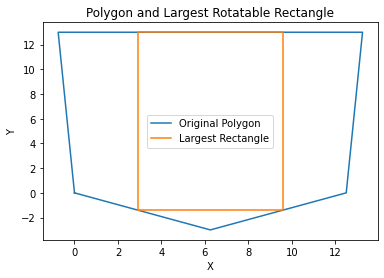

In [79]:
points=data['back_coordinate'][0]
# Find the largest rectangle with aspect ratio 2 after rotating the polygon
largest_rectangle = polygon_and_find_largest_rectangle_back(points, 2.16)

# Plot the original polygon and the largest rectangle
polygon = Polygon(points)
x, y = polygon.exterior.xy
plt.figure()
plt.plot(x, y, label="Original Polygon")

if largest_rectangle:
    x, y = largest_rectangle.exterior.xy
    plt.plot(x, y, label=f"Largest Rectangle")

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polygon and Largest Rotatable Rectangle')
plt.legend()
plt.show()

In [81]:
data['polygon_back']=data['back_coordinate'].apply(lambda x:pd.Series(polygon_and_find_largest_rectangle_back(x, 2.16)) )

In [82]:

data['polygon_back_area']= data['polygon_back'].apply(lambda rect: rect.area)
data['polygon_back_coord']= data['polygon_back'].apply(lambda rect: rect.exterior.coords)
data[['polygon_back_len','polygon_back_wid']]= data['polygon_back'].apply(lambda rect: 
                                                             pd.Series(calculate_distances(list(rect.exterior.coords))))

data['polygon_back_max_diagonal']=round(np.sqrt(data.polygon_back_len**2+data.polygon_back_wid**2),2)
data['polygon_back_max_diagonal_inch']=data['polygon_back_max_diagonal']/2.54

In [86]:


data.to_csv('all_data_rerrun_qc.csv')


In [85]:
data.columns

Index(['brand', 'style', 'menWomen', 'name', 'fabric', 'price',
       'maxHeightFront', 'minHeightFront', 'rivetHeightFront', 'maxWidthFront',
       'minWidthFront', 'maxHeightBack', 'minHeightBack', 'maxWidthBack',
       'minWidthBack', 'cutout', 'waistSize', 'updatedStyle', 'group',
       'priceGroup', 'front_x1', 'front_y1', 'front_x2', 'front_y2',
       'front_x3', 'front_y3', 'front_x4', 'front_y4', 'front_x5', 'front_y5',
       'back_x1', 'back_y1', 'back_x2', 'back_y2', 'back_x3', 'back_y3',
       'back_x4', 'back_y4', 'back_x5', 'back_y5', 'front_bottom_curve_x',
       'front_bottom_curve_y', 'front_top_curve_x', 'front_top_curve_y',
       'front_x', 'front_y', 'front_coordinate_generate',
       'front_coordinate_plot', 'back_x', 'back_y', 'front_coordinate',
       'back_coordinate', 'polygon_front', 'poly_angle_front',
       'polygon_front_area', 'polygon_front_coord', 'polygon_front_len',
       'polygon_front_wid', 'polygon_front_max_diagonal',
       'polygon_fr